# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


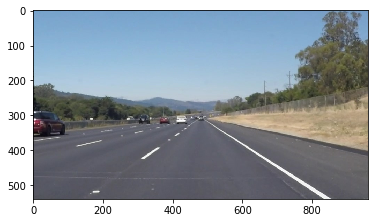

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def extrapolate_line(lane, x0 = 0, xf = 540):
    slopes = sorted(lane.keys())
    if len(slopes) > 4:
        trimmed_slopes = slopes[int(len(slopes)/4):-1*int(len(slopes)/4)]
    else:
        trimmed_slopes = slopes
    x_list = []
    y_list = []
    for slope in trimmed_slopes:
        x1,y1,x2,y2 = lane[slope][0]
        x_list.append(x1)
        x_list.append(x2)
        y_list.append(y1)
        y_list.append(y2)
    
    m, b = np.polyfit(x_list, y_list, 1)
    line_0 = (x0, int(m * x0 + b))
    line_f = (xf, int(m * xf + b))
    return (line_0, line_f)
    


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    y_size, x_size = img.shape[0:2]
    right_lane = {}
    left_lane = {}
    #Group images based on slope
    for line in lines:
        line_copy = np.copy(line)
        for x1,y1,x2,y2 in line:
            slope = (float(y2-y1)/float(x2-x1))
            if slope > 0.30:
                right_lane[slope] = line
            elif slope < -0.30:
                left_lane[slope] = line
            else:
                print("discarded slope:", slope)
    x0, xf = 0, x_size
    right_line_0, right_line_f = extrapolate_line(right_lane, x0, xf)
    left_line_0, left_line_f = extrapolate_line(left_lane, x0, xf)
    
    cv2.line(img, right_line_0, right_line_f, color, thickness)
    cv2.line(img, left_line_0, left_line_f, color, thickness)
            
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

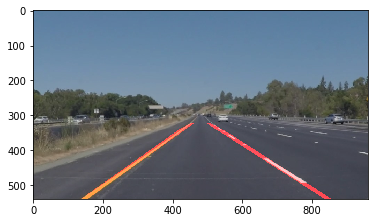

In [5]:
# Pipeline that draws a lane lines on iamage img received as
# a parameter and returns the resulting image.
def image_pipeline(img, kernel_size=5,
                   low_threshold = 50,
                   high_threshold = 150,
                   ):
    initial_image = np.copy(img)
    gray_image = grayscale(img)
    blured_image = gaussian_blur(gray_image, kernel_size)
    edged_image = canny(blured_image, low_threshold, high_threshold)
    
    imshape = gray_image.shape
    ysize, xsize = imshape[0:2]
    vertices = np.array([[(50,ysize),(xsize/2-30, 4.2*ysize/7), (xsize/2+30, 4.2*ysize/7), (xsize-50,ysize)]], dtype=np.int32)
    roi_edged_image = region_of_interest(edged_image, vertices)
    
    rho = 1
    theta = np.pi/180
    threshold = 15
    min_line_len = 10
    max_line_gap = 10
    lanes_image = hough_lines(roi_edged_image, rho, theta, threshold, min_line_len, max_line_gap)
    roi_lanes_image = region_of_interest(lanes_image, vertices)
    
    # Image combination parameters
    α=0.8
    β=1.
    λ=0
    result = weighted_img(roi_lanes_image, initial_image, α=0.8, β=1., λ=0.)

    return result

# Index -> {0-5}
image_index = 1

input_image = os.listdir("test_images/")[image_index]

image = mpimg.imread('test_images/'+ input_image)
processed_image = image_pipeline(image)
plt.imshow(processed_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    result = image_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

discarded slope: 0.0
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 4/222 [00:00<00:06, 33.89it/s]

discarded slope: 0.0
discarded slope: -0.05263157894736842


  9%|▊         | 19/222 [00:00<00:04, 41.35it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.125


 13%|█▎        | 28/222 [00:00<00:04, 41.31it/s]

discarded slope: 0.0


 17%|█▋        | 38/222 [00:00<00:04, 43.16it/s]

discarded slope: -0.08
discarded slope: 0.0
discarded slope: -0.058823529411764705


 22%|██▏       | 48/222 [00:01<00:04, 37.34it/s]

discarded slope: 0.0625
discarded slope: 0.0
discarded slope: -0.07692307692307693


 25%|██▌       | 56/222 [00:01<00:05, 29.84it/s]

discarded slope: 0.1


 27%|██▋       | 60/222 [00:01<00:05, 30.09it/s]

discarded slope: -0.12


 41%|████      | 90/222 [00:03<00:06, 20.93it/s]

discarded slope: 0.0


 43%|████▎     | 96/222 [00:03<00:05, 23.12it/s]

discarded slope: -0.08333333333333333


 47%|████▋     | 104/222 [00:04<00:06, 17.48it/s]

discarded slope: -0.14814814814814814
discarded slope: -0.2


 53%|█████▎    | 117/222 [00:04<00:05, 18.25it/s]

discarded slope: -0.19230769230769232


 59%|█████▊    | 130/222 [00:05<00:04, 18.61it/s]

discarded slope: -0.058823529411764705
discarded slope: -0.08695652173913043


 65%|██████▌   | 145/222 [00:06<00:03, 21.09it/s]

discarded slope: 0.0625


 76%|███████▌  | 168/222 [00:07<00:02, 24.91it/s]

discarded slope: 0.0
discarded slope: 0.05263157894736842


 82%|████████▏ | 181/222 [00:07<00:01, 26.03it/s]

discarded slope: 0.0
discarded slope: -0.15384615384615385
discarded slope: 0.06666666666666667


 86%|████████▌ | 190/222 [00:08<00:01, 22.96it/s]

discarded slope: 0.0
discarded slope: -0.15789473684210525


 91%|█████████ | 202/222 [00:08<00:00, 24.15it/s]

discarded slope: -0.11764705882352941
discarded slope: -0.12
discarded slope: 0.047619047619047616
discarded slope: 0.0
discarded slope: -0.1875
discarded slope: -0.0625
discarded slope: -0.13793103448275862
discarded slope: -0.12


 95%|█████████▌| 212/222 [00:09<00:00, 25.13it/s]

discarded slope: 0.0


100%|█████████▉| 221/222 [00:09<00:00, 19.13it/s]

discarded slope: 0.0


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 16.3 s, sys: 208 ms, total: 16.5 s
Wall time: 10.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 4/682 [00:00<00:17, 38.73it/s]

discarded slope: 0.0
discarded slope: -0.14285714285714285
discarded slope: 0.0
discarded slope: 0.05263157894736842
discarded slope: 0.0
discarded slope: 0.0


  1%|          | 8/682 [00:00<00:18, 36.12it/s]

discarded slope: 0.047619047619047616
discarded slope: 0.0
discarded slope: -0.058823529411764705
discarded slope: -0.05
discarded slope: 

  2%|▏         | 11/682 [00:00<00:21, 31.74it/s]

-0.05263157894736842
discarded slope: -0.14285714285714285


  2%|▏         | 14/682 [00:00<00:22, 29.63it/s]

discarded slope: 0.15789473684210525
discarded slope: 0.0


  3%|▎         | 18/682 [00:00<00:21, 30.96it/s]

discarded slope: 0.0
discarded slope: -0.12
discarded slope: -0.07407407407407407
discarded slope: 0.08333333333333333
discarded slope: -0.09090909090909091
discarded slope: 0.045454545454545456
discarded slope: 0.0
discarded slope: 0.0


  3%|▎         | 23/682 [00:00<00:19, 33.87it/s]

discarded slope: -0.09090909090909091
discarded slope: 0.0
discarded slope: -0.07142857142857142


  5%|▍         | 33/682 [00:00<00:17, 36.61it/s]

discarded slope: 0.0
discarded slope: -0.047619047619047616
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.15384615384615385
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.045454545454545456
discarded slope: 0.045454545454545456
discarded slope: -0.09090909090909091
discarded slope: 0.058823529411764705
discarded slope: -0.125
discarded slope: 0.18181818181818182


  6%|▌         | 41/682 [00:01<00:20, 31.18it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.09523809523809523
discarded slope: 0.14285714285714285
discarded slope: 0.0625
discarded slope: 0.0625


  7%|▋         | 49/682 [00:01<00:21, 29.11it/s]

discarded slope: 0.0967741935483871
discarded slope: 0.0
discarded slope: 0.1388888888888889
discarded slope: 0.05
discarded slope: 0.0
discarded slope: -0.13636363636363635
discarded slope: 0.0


  8%|▊         | 56/682 [00:01<00:24, 25.13it/s]

discarded slope: 0.11764705882352941
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.07142857142857142
discarded slope: 0.05
discarded slope: 

  9%|▉         | 62/682 [00:02<00:26, 23.81it/s]

0.11764705882352941
discarded slope: 0.0
discarded slope: -0.03571428571428571
discarded slope: -0.16666666666666666
discarded slope: -0.13333333333333333


 10%|▉         | 68/682 [00:02<00:27, 22.40it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0625
discarded slope: -0.21428571428571427


 10%|█         | 71/682 [00:02<00:26, 23.48it/s]

discarded slope: 0.0
discarded slope: -0.058823529411764705
discarded slope: 0.0
discarded slope: -0.08333333333333333
discarded slope: 0.07142857142857142
discarded slope: 0.045454545454545456
discarded slope: 0.14285714285714285
discarded slope: 0.0


 12%|█▏        | 80/682 [00:02<00:26, 22.78it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.08333333333333333
discarded slope: -0.1
discarded slope: 0.05555555555555555


 12%|█▏        | 83/682 [00:03<00:25, 23.90it/s]

discarded slope: 0.0
discarded slope: -0.15384615384615385
discarded slope: -0.07142857142857142
discarded slope: -0.125
discarded slope: -0.10526315789473684
discarded slope: -0.05263157894736842
discarded slope: -0.07692307692307693


 14%|█▍        | 96/682 [00:03<00:22, 25.88it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.05555555555555555


 15%|█▍        | 102/682 [00:03<00:25, 22.60it/s]

discarded slope: -0.038461538461538464
discarded slope: -0.06666666666666667
discarded slope: 0.0
discarded slope: 0.14285714285714285


 16%|█▌        | 108/682 [00:04<00:22, 25.11it/s]

discarded slope: 0.23076923076923078
discarded slope: -0.08333333333333333
discarded slope: 0.05263157894736842
discarded slope: 0.0


 17%|█▋        | 114/682 [00:04<00:25, 22.52it/s]

discarded slope: -0.13043478260869565
discarded slope: -0.07692307692307693


 17%|█▋        | 117/682 [00:04<00:25, 21.78it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.041666666666666664
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 18%|█▊        | 120/682 [00:04<00:26, 21.50it/s]

discarded slope: -0.0625
discarded slope: -0.047619047619047616
discarded slope: 0.0
discarded slope: 0.05
discarded slope: -0.09090909090909091
discarded slope: 0.05555555555555555


 19%|█▊        | 127/682 [00:05<00:31, 17.85it/s]

discarded slope: -0.07692307692307693
discarded slope: 0.0
discarded slope: 0.0


 19%|█▉        | 129/682 [00:05<00:37, 14.71it/s]

discarded slope: 0.0
discarded slope: -0.1
discarded slope: 0.0
discarded slope: 0.0625


 20%|██        | 138/682 [00:05<00:30, 18.06it/s]

discarded slope: 0.0
discarded slope: 0.10526315789473684
discarded slope: -0.09090909090909091
discarded slope: 0.0
discarded slope: 0.0


 21%|██        | 141/682 [00:05<00:28, 18.68it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 21%|██▏       | 146/682 [00:06<00:29, 18.26it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.058823529411764705


 22%|██▏       | 151/682 [00:06<00:26, 19.87it/s]

discarded slope: -0.13043478260869565
discarded slope: -0.0625


 23%|██▎       | 157/682 [00:06<00:26, 19.70it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope:

 24%|██▍       | 163/682 [00:06<00:25, 20.21it/s]

 0.05555555555555555
discarded slope: 0.0
discarded slope: -0.0625
discarded slope: 0.08
discarded slope: -0.03571428571428571
discarded slope: 0.09090909090909091


 24%|██▍       | 166/682 [00:07<00:23, 21.62it/s]

discarded slope: 0.0
discarded slope: 0.06666666666666667
discarded slope: 0.0
discarded slope: -0.05263157894736842
discarded slope: 0.0
discarded slope: -0.06666666666666667


 25%|██▌       | 172/682 [00:07<00:24, 20.41it/s]

discarded slope: 0.0
discarded slope: 0.1
discarded slope: 0.08333333333333333
discarded slope: -0.08


 27%|██▋       | 181/682 [00:07<00:24, 20.30it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.1
discarded slope: 0.0
discarded slope: -0.05
discarded slope: 0.0
discarded slope: 0.0


 27%|██▋       | 187/682 [00:08<00:22, 21.57it/s]

discarded slope: 0.0
discarded slope: -0.08695652173913043
discarded slope: 0.0625
discarded slope: 0.0
discarded slope: -0.05


 28%|██▊       | 194/682 [00:08<00:22, 21.88it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 29%|██▉       | 197/682 [00:08<00:22, 21.25it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.1111111111111111
discarded slope: 0.047619047619047616
discarded slope: 0.0
discarded slope: -0.08695652173913043


 30%|██▉       | 203/682 [00:08<00:20, 23.49it/s]

discarded slope: 0.0
discarded slope: 0.16666666666666666
discarded slope: 0.0
discarded slope: -0.08695652173913043

 31%|███       | 210/682 [00:09<00:19, 24.33it/s]


discarded slope: 0.0625
discarded slope: 0.0
discarded slope: 0.2
discarded slope: -0.041666666666666664
discarded slope: 0.21428571428571427


 31%|███       | 213/682 [00:09<00:20, 23.06it/s]

discarded slope: -0.15


 32%|███▏      | 220/682 [00:09<00:19, 24.25it/s]

discarded slope: -0.08333333333333333
discarded slope: -0.047619047619047616
discarded slope: -0.07142857142857142
discarded slope: -0.05555555555555555


 33%|███▎      | 223/682 [00:09<00:22, 19.98it/s]

discarded slope: -0.09523809523809523
discarded slope: -0.14285714285714285
discarded slope: -0.037037037037037035
discarded slope: -0.058823529411764705
discarded slope: -0.03571428571428571


 34%|███▎      | 230/682 [00:09<00:19, 23.01it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.18181818181818182
discarded slope: -0.05
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0625


 35%|███▍      | 236/682 [00:10<00:21, 20.38it/s]

discarded slope: 0.05555555555555555
discarded slope: -0.10526315789473684
discarded slope: 0.0
discarded slope: 0.043478260869565216


 35%|███▌      | 242/682 [00:10<00:21, 20.30it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 36%|███▌      | 245/682 [00:10<00:20, 21.06it/s]

discarded slope: -0.047619047619047616
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.041666666666666664
discarded slope: 0.06666666666666667
discarded slope: -0.10526315789473684
discarded slope: 0.037037037037037035


 37%|███▋      | 255/682 [00:11<00:18, 23.47it/s]

discarded slope: 0.09090909090909091
discarded slope: 0.1111111111111111
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.058823529411764705
discarded slope: -0.0625
discarded slope: -0.07692307692307693
discarded slope: -0.0625


 39%|███▊      | 264/682 [00:11<00:19, 21.05it/s]

discarded slope: -0.058823529411764705
discarded slope: 0.07142857142857142
discarded slope: 0.09090909090909091


 40%|███▉      | 270/682 [00:11<00:20, 20.34it/s]

discarded slope: -0.058823529411764705
discarded slope: -0.2


 40%|████      | 274/682 [00:12<00:18, 22.27it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.0625
discarded slope: -0.16666666666666666


 41%|████      | 280/682 [00:12<00:19, 20.90it/s]

discarded slope: -0.029411764705882353
discarded slope: -0.07894736842105263
discarded slope: -0.08823529411764706
discarded slope: -0.02631578947368421
discarded slope: -0.047619047619047616
discarded slope: 0.045454545454545456
discarded slope: -0.04878048780487805
discarded slope: 0.09375
discarded slope: -0.058823529411764705
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.09523809523809523
discarded slope: 0.0
discarded slope: -0.058823529411764705


 42%|████▏     | 286/682 [00:12<00:17, 22.54it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.06666666666666667
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.020833333333333332
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.03571428571428571
discarded slope: 0.0
discarded slope: -0.06666666666666667
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.041666666666666664
discarded slope: -0.08695652173913043
discarded slope: 0.08695652173913043
discarded slope: 0.0

 42%|████▏     | 289/682 [00:12<00:18, 21.73it/s]


discarded slope: 0.03225806451612903
discarded slope: 0.0
discarded slope: -0.0425531914893617
discarded slope: -0.041666666666666664
discarded slope: 0.06896551724137931
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.038461538461538464
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.041666666666666664
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.125
discarded slope: -0.030303030303030304
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.043478260869565216
discarded slope: 0.0
discarded slope: 0.027777777777777776
discarded slope: -0.014084507042253521
discarded slope: -0.04
discarded slope: 0.0
discarded slope: 0.05263157894736842
discarded slope: 0.0
discarded slope: 0.023809523809523808
discarded slope: -0.0625
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0625
discar

 43%|████▎     | 295/682 [00:13<00:17, 22.23it/s]

discarded slope: 0.0
discarded slope: 0.031746031746031744
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.03571428571428571
discarded slope: 0.023255813953488372
discarded slope: 0.0
discarded slope: -0.034482758620689655
discarded slope: 0.05555555555555555
discarded slope: 0.0
discarded slope: 0.14285714285714285
discarded slope: 0.0
discarded slope: -0.043478260869565216
discarded slope: 0.0
discarded slope: -0.1
discarded slope: 0.0


 44%|████▎     | 298/682 [00:13<00:17, 22.42it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.125


 45%|████▍     | 306/682 [00:13<00:23, 15.80it/s]

discarded slope: -0.07142857142857142
discarded slope: -0.18181818181818182
discarded slope: -0.15384615384615385
discarded slope: -0.07407407407407407


 46%|████▌     | 311/682 [00:13<00:22, 16.68it/s]

discarded slope: 0.043478260869565216
discarded slope: -0.045454545454545456
discarded slope: -0.0625


 46%|████▋     | 317/682 [00:14<00:20, 17.81it/s]

discarded slope: 0.15384615384615385
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.09523809523809523
discarded slope: 0.0
discarded slope: 0.09090909090909091
discarded slope: 0.0


 47%|████▋     | 323/682 [00:14<00:18, 19.48it/s]

discarded slope: 0.0
discarded slope: 0.045454545454545456
discarded slope: 0.0
discarded slope: -0.1


 48%|████▊     | 330/682 [00:14<00:18, 19.10it/s]

discarded slope: 0.0
discarded slope: -0.05263157894736842
discarded slope: -0.038461538461538464
discarded slope: 0.0
discarded slope: -0.25
discarded slope: 0.0


 49%|████▉     | 337/682 [00:15<00:17, 20.16it/s]

discarded slope: 0.0
discarded slope: -0.045454545454545456
discarded slope: 0.0


 50%|█████     | 343/682 [00:15<00:16, 20.93it/s]

discarded slope: 0.0
discarded slope: -0.047619047619047616
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 51%|█████     | 346/682 [00:15<00:18, 18.60it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.041666666666666664


 51%|█████▏    | 350/682 [00:15<00:17, 18.46it/s]

discarded slope: -0.1111111111111111
discarded slope: -0.14285714285714285


 52%|█████▏    | 355/682 [00:16<00:17, 18.83it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.07407407407407407
discarded slope: -0.0625


 53%|█████▎    | 362/682 [00:16<00:17, 18.37it/s]

discarded slope: -0.04
discarded slope: -0.08695652173913043
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 54%|█████▎    | 366/682 [00:16<00:17, 18.29it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.043478260869565216
discarded slope: 0.0
discarded slope: -0.15384615384615385
discarded slope: 0.16666666666666666
discarded slope: 0.0
discarded slope: -0.16666666666666666
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.1
discarded slope: -0.15384615384615385
discarded slope: 0.037037037037037035
discarded slope: 0.0
discarded slope:

 54%|█████▍    | 368/682 [00:17<00:19, 15.81it/s]

 0.034482758620689655
discarded slope: -0.05555555555555555
discarded slope: 0.0
discarded slope: -0.047619047619047616
discarded slope: -0.030303030303030304
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.041666666666666664


 55%|█████▍    | 372/682 [00:17<00:21, 14.29it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.17142857142857143
discarded slope: 0.07692307692307693
discarded slope: 0.041666666666666664
discarded slope: -0.15384615384615385
discarded slope: 0.08695652173913043
discarded slope: -0.125
discarded slope: 0.06666666666666667
discarded slope: -0.23529411764705882


 55%|█████▌    | 376/682 [00:17<00:20, 15.10it/s]

discarded slope: -0.08333333333333333


 56%|█████▌    | 380/682 [00:17<00:22, 13.50it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.18181818181818182
discarded slope: 0.06666666666666667


 57%|█████▋    | 386/682 [00:18<00:23, 12.67it/s]

discarded slope: -0.058823529411764705
discarded slope: 0.10526315789473684


 57%|█████▋    | 391/682 [00:18<00:18, 15.58it/s]

discarded slope: 0.0
discarded slope: 0.047619047619047616
discarded slope: -0.0625
discarded slope: 0.0
discarded slope: -0.05555555555555555


 58%|█████▊    | 397/682 [00:19<00:21, 13.31it/s]

discarded slope: -0.058823529411764705
discarded slope: -0.05263157894736842


 59%|█████▉    | 403/682 [00:19<00:21, 12.95it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 59%|█████▉    | 405/682 [00:19<00:23, 11.72it/s]

discarded slope: 0.0
discarded slope: 0.0


 60%|█████▉    | 409/682 [00:20<00:22, 12.16it/s]

discarded slope: -0.07692307692307693
discarded slope: -0.17647058823529413
discarded slope: -0.13333333333333333


 61%|██████    | 413/682 [00:20<00:20, 13.15it/s]

discarded slope: 0.0
discarded slope: 0.0


 61%|██████    | 415/682 [00:20<00:20, 12.94it/s]

discarded slope: 0.0
discarded slope: 0.0


 62%|██████▏   | 421/682 [00:21<00:19, 13.71it/s]

discarded slope: -0.045454545454545456
discarded slope: 0.05555555555555555
discarded slope: -0.09090909090909091
discarded slope: -0.12
discarded slope: -0.06666666666666667


 62%|██████▏   | 425/682 [00:21<00:18, 14.12it/s]

discarded slope: 0.0
discarded slope: -0.08695652173913043


 63%|██████▎   | 429/682 [00:21<00:19, 13.20it/s]

discarded slope: 0.0
discarded slope: -0.10526315789473684
discarded slope: 0.0
discarded slope: -0.06666666666666667
discarded slope: 0.0
discarded slope: 0.0


 63%|██████▎   | 433/682 [00:21<00:17, 14.20it/s]

discarded slope: -0.07142857142857142
discarded slope: -0.08333333333333333


 64%|██████▍   | 439/682 [00:22<00:18, 12.81it/s]

discarded slope: -0.2
discarded slope: 0.0
discarded slope: 0.07142857142857142
discarded slope: 0.0
discarded slope: -0.2
discarded slope: -0.18181818181818182
discarded slope: -0.2
discarded slope: 0.07692307692307693
discarded slope: 

 65%|██████▌   | 444/682 [00:22<00:14, 15.90it/s]

0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.21428571428571427
discarded slope: 0.13636363636363635


 66%|██████▌   | 447/682 [00:22<00:13, 16.90it/s]

discarded slope: 0.05263157894736842
discarded slope: -0.1
discarded slope: -0.14285714285714285


 67%|██████▋   | 454/682 [00:23<00:14, 15.67it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 68%|██████▊   | 461/682 [00:23<00:11, 19.49it/s]

discarded slope: 0.0
discarded slope: -0.10526315789473684
discarded slope: 0.04
discarded slope: -0.0625


 68%|██████▊   | 464/682 [00:23<00:11, 18.85it/s]

discarded slope: -0.06666666666666667
discarded slope: 0.0
discarded slope: -0.125
discarded slope: 0.0
discarded slope: -0.06666666666666667
discarded slope: 0.0
discarded slope: -0.15384615384615385


 69%|██████▉   | 471/682 [00:24<00:15, 13.55it/s]

discarded slope: -0.08333333333333333
discarded slope: 0.05263157894736842
discarded slope: -0.06666666666666667
discarded slope: 0.05263157894736842


 70%|██████▉   | 477/682 [00:24<00:16, 12.77it/s]

discarded slope: 0.09090909090909091
discarded slope: 0.0
discarded slope: 0.0


 70%|███████   | 479/682 [00:24<00:16, 12.65it/s]

discarded slope: 0.0
discarded slope: 0.0


 71%|███████   | 483/682 [00:25<00:16, 12.23it/s]

discarded slope: -0.09090909090909091
discarded slope: -0.07407407407407407
discarded slope: -0.06666666666666667


 72%|███████▏  | 490/682 [00:25<00:12, 15.37it/s]

discarded slope: 0.08333333333333333
discarded slope: -0.09090909090909091
discarded slope: -0.2
discarded slope: 0.0
discarded slope: 0.0


 73%|███████▎  | 496/682 [00:25<00:10, 17.79it/s]

discarded slope: 0.0
discarded slope: -0.125
discarded slope: -0.14285714285714285


 73%|███████▎  | 501/682 [00:26<00:09, 18.85it/s]

discarded slope: -0.06666666666666667
discarded slope: 0.0


 74%|███████▍  | 506/682 [00:26<00:09, 18.24it/s]

discarded slope: 0.06666666666666667
discarded slope: -0.10526315789473684
discarded slope: -0.08695652173913043
discarded slope: 0.0


 75%|███████▌  | 514/682 [00:26<00:08, 20.44it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.06666666666666667
discarded slope: -0.06666666666666667


 76%|███████▌  | 520/682 [00:27<00:08, 19.29it/s]

discarded slope: 0.1
discarded slope: -0.08695652173913043
discarded slope: -0.058823529411764705
discarded slope: 0.07407407407407407


 77%|███████▋  | 526/682 [00:27<00:07, 19.72it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 78%|███████▊  | 529/682 [00:27<00:07, 20.26it/s]

discarded slope: 0.06666666666666667
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.045454545454545456
discarded slope: -0.07407407407407407


 79%|███████▉  | 540/682 [00:28<00:07, 19.75it/s]

discarded slope: -0.08
discarded slope: -0.08
discarded slope: -0.1
discarded slope: 0.0
discarded slope: 0.0


 81%|████████  | 552/682 [00:28<00:06, 19.10it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0


 82%|████████▏ | 557/682 [00:29<00:08, 14.42it/s]

discarded slope: -0.1
discarded slope: -0.17647058823529413
discarded slope: -0.05555555555555555


 83%|████████▎ | 563/682 [00:29<00:09, 13.16it/s]

discarded slope: -0.07692307692307693
discarded slope: 0.0


 83%|████████▎ | 567/682 [00:30<00:08, 13.23it/s]

discarded slope: 0.0
discarded slope: -0.1


 84%|████████▎ | 571/682 [00:30<00:08, 13.64it/s]

discarded slope: 0.0
discarded slope: -0.09523809523809523


 84%|████████▍ | 576/682 [00:30<00:06, 16.15it/s]

discarded slope: 0.09090909090909091
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.07142857142857142
discarded slope: 0.125


 85%|████████▍ | 578/682 [00:30<00:07, 13.94it/s]

discarded slope: -0.058823529411764705
discarded slope: 0.1
discarded slope: 0.0


 85%|████████▌ | 582/682 [00:31<00:06, 14.73it/s]

discarded slope: 0.17647058823529413
discarded slope: -0.038461538461538464
discarded slope: -0.10526315789473684


 86%|████████▌ | 587/682 [00:31<00:05, 16.24it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.07142857142857142
discarded slope: -0.1
discarded slope: 0.07142857142857142
discarded slope: 0.05263157894736842


 87%|████████▋ | 593/682 [00:31<00:05, 16.76it/s]

discarded slope: 0.2777777777777778
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.0625
discarded slope: -0.09090909090909091
discarded slope: 0.0


 87%|████████▋ | 596/682 [00:31<00:04, 18.01it/s]

discarded slope: -0.17391304347826086
discarded slope: 0.16
discarded slope: -0.09090909090909091


 88%|████████▊ | 600/682 [00:32<00:04, 17.69it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.043478260869565216
discarded slope: -0.05555555555555555
discarded slope: 0.041666666666666664


 89%|████████▊ | 605/682 [00:32<00:04, 17.05it/s]

discarded slope: 0.11764705882352941
discarded slope: 0.0
discarded slope: -0.05
discarded slope: -0.041666666666666664
discarded slope: 0.25


 90%|████████▉ | 612/682 [00:32<00:04, 14.91it/s]

discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.07692307692307693
discarded slope: 0.0


 90%|█████████ | 616/682 [00:33<00:04, 14.76it/s]

discarded slope: 0.14814814814814814


 91%|█████████ | 618/682 [00:33<00:04, 15.21it/s]

discarded slope: 0.17647058823529413
discarded slope: 0.0
discarded slope: -0.15789473684210525
discarded slope: -0.11764705882352941
discarded slope: -0.125


 91%|█████████▏| 623/682 [00:33<00:03, 15.80it/s]

discarded slope: -0.07142857142857142
discarded slope: -0.0625
discarded slope: 0.058823529411764705
discarded slope: -0.047619047619047616
discarded slope: 0.0


 92%|█████████▏| 627/682 [00:33<00:04, 13.68it/s]

discarded slope: 0.0
discarded slope: -0.06666666666666667
discarded slope: 

 92%|█████████▏| 630/682 [00:33<00:03, 15.71it/s]

0.0
discarded slope: 0.0
discarded slope: 0.05
discarded slope: 0.1
discarded slope: -0.038461538461538464


 94%|█████████▎| 638/682 [00:34<00:02, 16.51it/s]

discarded slope: 0.1
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.08
discarded slope: 0.0


 94%|█████████▍| 642/682 [00:34<00:02, 14.18it/s]

discarded slope: 0.0
discarded slope: -0.16666666666666666


 94%|█████████▍| 644/682 [00:34<00:02, 14.09it/s]

discarded slope: -0.08333333333333333
discarded slope: -0.07142857142857142


 95%|█████████▌| 650/682 [00:35<00:02, 12.64it/s]

discarded slope: -0.0625
discarded slope: -0.07692307692307693
discarded slope: -0.045454545454545456
discarded slope: -0.06666666666666667
discarded slope: -0.05555555555555555
discarded slope:

 96%|█████████▌| 655/682 [00:35<00:01, 15.78it/s]

 -0.045454545454545456
discarded slope: 0.2
discarded slope: 0.0
discarded slope: -0.1111111111111111


 96%|█████████▋| 657/682 [00:35<00:01, 16.42it/s]

discarded slope: -0.058823529411764705
discarded slope: -0.07142857142857142


 97%|█████████▋| 661/682 [00:36<00:01, 15.50it/s]

discarded slope: 0.08333333333333333
discarded slope: -0.058823529411764705
discarded slope: 0.0
discarded slope: -0.05555555555555555


 98%|█████████▊| 666/682 [00:36<00:00, 18.21it/s]

discarded slope: 0.0
discarded slope: -0.1
discarded slope: 0.0


 98%|█████████▊| 670/682 [00:36<00:00, 16.84it/s]

discarded slope: -0.08695652173913043
discarded slope: -0.11764705882352941


 99%|█████████▉| 674/682 [00:36<00:00, 17.31it/s]

discarded slope: 0.1
discarded slope: 0.0
discarded slope: -0.037037037037037035
discarded slope: 0.0
discarded slope: 0.0
discarded slope: -0.1
discarded slope: 0.0
discarded slope: 0.0
discarded slope: 0.045454545454545456
discarded slope: -0.1
discarded slope: -0.07692307692307693
discarded slope: -0.043478260869565216
discarded slope: -0.07142857142857142
discarded slope: 0.03125
discarded slope: 0.0
discarded slope: -0.06896551724137931
discarded slope: 0.0
discarded slope: 0.0


 99%|█████████▉| 676/682 [00:36<00:00, 15.79it/s]

discarded slope: -0.05357142857142857
discarded slope: -0.058823529411764705
discarded slope: -0.05714285714285714
discarded slope: 0.0
discarded slope: -0.034482758620689655
discarded slope: -0.08
discarded slope: 0.0
discarded slope: 0.0


100%|█████████▉| 680/682 [00:37<00:00, 12.99it/s]

discarded slope: 0.0
discarded slope: -0.045454545454545456
discarded slope: -0.06666666666666667
discarded slope: -0.041666666666666664
discarded slope: 0.25


100%|█████████▉| 681/682 [00:37<00:00, 18.25it/s]


discarded slope: -0.03571428571428571
discarded slope: -0.06666666666666667
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 52.7 s, sys: 704 ms, total: 53.4 s
Wall time: 38.4 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))